# Explainable AI, Homework 6, Aleksandra Mysiak

## Task 1

## Demographic parity
This is the ratio of probabilities of $\hat{Y}=1$. In this case, we have 65/100 for Blue, and for Red -- 0.5. This gives us a ratio of 130%.
## Equal opportunity
This is the ratio of probabilities of $\hat{Y}=1$ given $Y=1$. For Blue, we have 60/80, and for Red -- again 0.5. This gives a ratio of 150%.
## Predictive rate parity
### Positive
This is the ratio of probabilities of $Y=1$ given $\hat{Y}=1$. For Blue, we have 60/65, and for Red -- 0.5. This gives a ratio of around 185%.
### Negative
This is the ratio of probabilities of $Y=1$ given $\hat{Y}=0$. For Blue, we have 20/35, and for Red -- 0.5. This gives a ratio of around 114%.

## Task 2
Fairness analysis on [adult income dataset](https://www.kaggle.com/datasets/wenruliu/adult-income-dataset?resource=download).

## Single model analysis
For the reference model, I have chosen an XGBoost classifier, trained on all available data, with default hyperparameters except `max_depth`, which was manually set to 7.

The model has an accuracy of 87.6% and an f1 score of 71.6%. As such, it seems to be a decent predictor of the two income categories.

A plot of fairness statistics for the model can be found below. The protected attribute chosen for analysis is gender. We can see that two out of five statistics are out of our fairness bounds -- predictive equality (which was not mentioned in the task description) and statistical parity. The scores here seem to be significantly out of bounds, which indicates a high level of dependence of our model on the protected feature. This is not surprising, considering that our model was trained on data that includes this feature.

![](model.png)

## Alternative model comparison
To get an alternative model, I have changed the `max_depth` parameter to 2. This decreases the model flexibility, which, intuitively, should decrease it's accuracy and increase dependency on the protected feature, bringing fairness statistics into more problematic regions.

The second model has an accuracy of 87.5% and an f1 score of 70.6%, which is a slight decrease, as expected.

Below, we can see fairness statistics for the two models plotted together. We can see that all of the values except accuracy equality seem to have worsened, with equal opportunity being additionally pushed out into the zone of concern. Again, this is an expected result.

![](model_2.png)

## Bias mitigation
The selected bias mitigation strategy is `reweight` from `dalex`, which is an example of a data pre-processing strategy. It weights samples to balance out the bias.

Below, we can see a comparison of the original model and the reweighted one, in terms of fairness statistics. As expected, the reweighted model has mostly values of statistics that are closer to 1, with the notable exceptions of equal opportunity ratio and predictive parity ratio. Since it is theoretically impossible to improve all the statistics, this is not a surprising result.

We can see that the statistic that was previously the most offensive -- predictive equality ratio -- is significantly reduced. It does not, however, manage to exit the area of concern. The same effect can be observed for statistical parity ratio.

An additional statistic was pushed into the concering area -- predictive parity ratio. In total, this means our mitigation actually increased the number of concerning statistics. We can see, however, that the average absolute difference between the values and the perfect score of 1 decreased. The qualitative result is a byproduct of the fact that the two statistics mentioned above, that still remain in the area of concern, had values so far away from perfect that even a significant improvement was not enough to de-classify them as biased. Any reduction, however, has it cost in other metrics.

![](reweight.png)

## Performance analysis
Below, we have a table of performances of the 3 models, and a plot of fairness statistics for all 3 of them.

There is no correlation between performance and fairness in the expected sense. The XGBoost model with `max_depth=2` performs worse in both terms, which means that it is simply not a great model, with too little flexibility.

While the reweighted model performs worse than the original one, the difference is not very large. As noted above, the fairness improvement is also far from perfect -- intuitively, however, it seems to be worth the less than 1 percentage point accuracy decrease.

| model                    | accuracy | F1   |
|--------------------------|----------|------|
| `max_depth=7`            | .876     | .716 |
| `max_depth=2`            | .875     | .706 |
| `max_dept=7`, reweighted | .872     | .698 |

![](all_models.png)

## Appendix

### 1. Train a model for the selected dataset.

In [3]:
import dalex as dx
import xgboost

import sklearn
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings("ignore")


In [17]:
X = pd.read_csv("../adult.csv")
X["income"] = (X["income"] == ">50K").astype(int)
X = pd.get_dummies(X, drop_first=True)

In [18]:
X.head()

,age,fnlwgt,educational-num,capital-gain,capital-loss,hours-per-week,income,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,...,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
0,25,226802,7,0,0,40,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,38,89814,9,0,0,50,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,28,336951,12,0,0,40,1,0,1,0,...,0,0,0,0,0,0,0,1,0,0
3,44,160323,10,7688,0,40,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,18,103497,10,0,0,30,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [19]:
y = X["income"]
X = X.drop("income", axis=1)

In [20]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.33, random_state=42)

In [45]:
model = xgboost.XGBClassifier(
    max_depth=7, 
    use_label_encoder=False, 
    eval_metric="logloss",
    
    enable_categorical=True,
    tree_method="hist"
)

model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=True,
              eval_metric='logloss', gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_to_onehot=4, max_delta_step=0, max_depth=7,
              max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [58]:
def pf_xgboost_classifier_categorical(model, df):
    df.loc[:, df.dtypes == 'object'] =\
        df.select_dtypes(['object'])\
        .apply(lambda x: x.astype('category'))
    return model.predict_proba(df)[:, 1]

explainer = dx.Explainer(model, X_test, y_test, predict_function=pf_xgboost_classifier_categorical, label="XGBClassifier with max_depth=7")

Preparation of a new explainer is initiated

  -> data              : 16118 rows 100 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 16118 values
  -> model_class       : xgboost.sklearn.XGBClassifier (default)
  -> label             : XGBClassifier with max_depth=7
  -> predict function  : <function pf_xgboost_classifier_categorical at 0x7fce5331f4c0> will be used
  -> predict function  : Accepts only pandas.DataFrame, numpy.ndarray causes problems.
  -> predicted values  : min = 2.71e-06, mean = 0.237, max = 1.0
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.999, mean = -0.00124, max = 0.997
  -> model_info        : package xgboost

A new explainer has been created!


In [59]:
explainer.model_performance()

,recall,precision,f1,accuracy,auc
XGBClassifier with max_depth=7,0.66465,0.776344,0.716168,0.875729,0.928917


### 2. For the selected protected attribute (age, gender, race) calculate the following fairness coefficients: Statistical parity, Equal opportunity, Predictive parity.

In [60]:
protected_variable = X_test.gender_Male.apply(lambda x: "male" if x else "female")
privileged_group = "male"

fobject = explainer.model_fairness(
    protected=protected_variable,
    privileged=privileged_group
)

In [61]:
fobject.fairness_check()

Bias detected in 2 metrics: FPR, STP

Conclusion: your model is not fair because 2 or more criteria exceeded acceptable limits set by epsilon.

Ratios of metrics, based on 'male'. Parameter 'epsilon' was set to 0.8 and therefore metrics should be within (0.8, 1.25)
             TPR       ACC       PPV       FPR       STP
female  0.883136  1.117438  1.037516  0.211765  0.301527


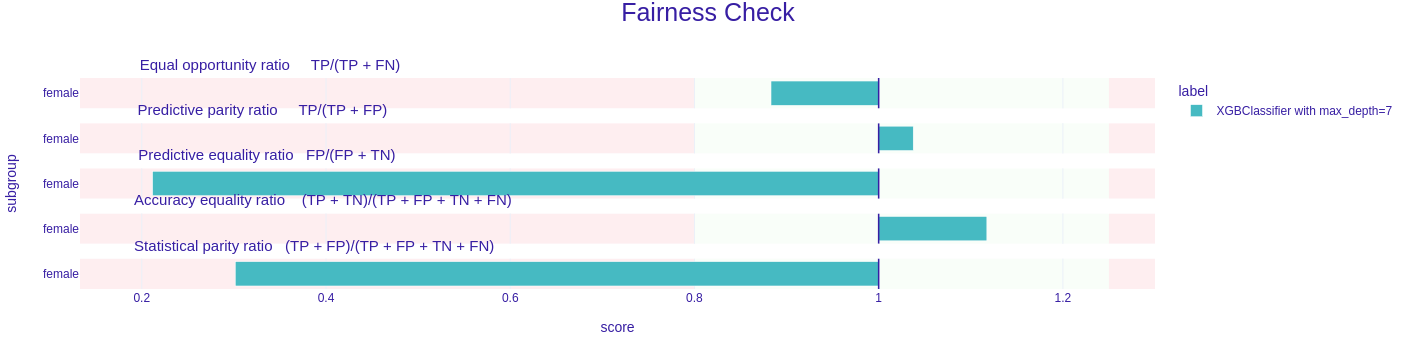

In [62]:
fobject.plot()

### 3. Train another model (different hyperparameters, feature transformations etc.) and see how the coefficients Statistical parity, Equal opportunity, Predictive parity behave for it.

In [63]:
model_2 = xgboost.XGBClassifier(
    max_depth=2, 
    use_label_encoder=False, 
    eval_metric="logloss",
    
    enable_categorical=True,
    tree_method="hist"
)

model_2.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=True,
              eval_metric='logloss', gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_to_onehot=4, max_delta_step=0, max_depth=2,
              max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [64]:
explainer_2 = dx.Explainer(model_2, X_test, y_test, predict_function=pf_xgboost_classifier_categorical, label="XGBClassifier with max_depth=2")

Preparation of a new explainer is initiated

  -> data              : 16118 rows 100 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 16118 values
  -> model_class       : xgboost.sklearn.XGBClassifier (default)
  -> label             : XGBClassifier with max_depth=2
  -> predict function  : <function pf_xgboost_classifier_categorical at 0x7fce5331f4c0> will be used
  -> predict function  : Accepts only pandas.DataFrame, numpy.ndarray causes problems.
  -> predicted values  : min = 0.000123, mean = 0.239, max = 0.999
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.993, mean = -0.00279, max = 0.997
  -> model_info        : package xgboost

A new explainer has been created!


In [65]:
explainer_2.model_performance()

,recall,precision,f1,accuracy,auc
XGBClassifier with max_depth=2,0.638085,0.790486,0.706156,0.874736,0.928471


In [66]:
fobject_2 = explainer_2.model_fairness(
    protected=protected_variable,
    privileged=privileged_group
)

In [67]:
fobject_2.fairness_check()

Bias detected in 3 metrics: TPR, FPR, STP

Conclusion: your model is not fair because 2 or more criteria exceeded acceptable limits set by epsilon.

Ratios of metrics, based on 'male'. Parameter 'epsilon' was set to 0.8 and therefore metrics should be within (0.8, 1.25)
             TPR       ACC       PPV       FPR       STP
female  0.793313  1.111374  1.058599  0.168831  0.266932


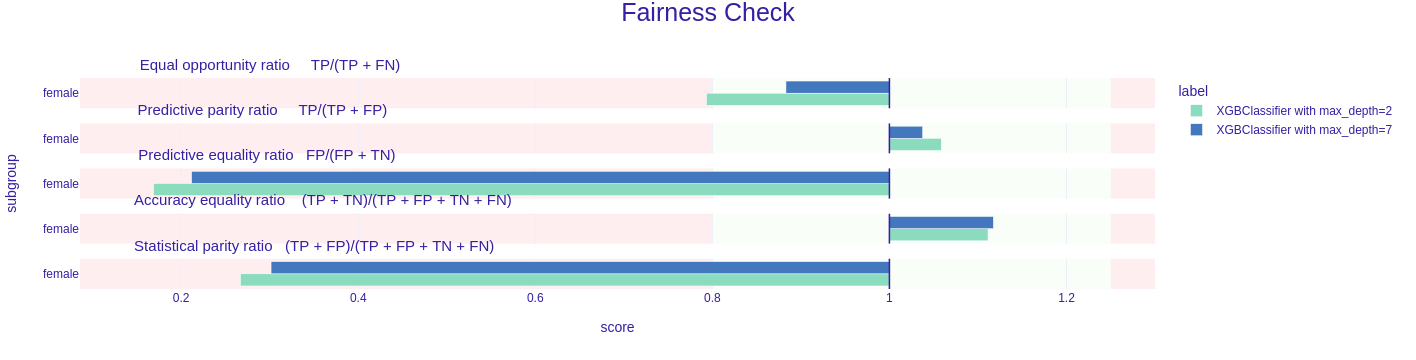

In [68]:
fobject_2.plot(fobject)

### 4. Apply the selected bias mitigation technique on the first model. Check how Statistical parity, Equal opportunity, Predictive parity coefficients behave after this correction.

In [69]:
protected_variable_train = X_train.gender_Male.apply(lambda x: "male" if x else "female")

In [75]:
sample_weight = dx.fairness.reweight(
    protected_variable_train, 
    y_train, 
    verbose=False
)
model_reweight = xgboost.XGBClassifier(
    max_depth=7, 
    use_label_encoder=False, 
    eval_metric="logloss",
    
    enable_categorical=True,
    tree_method="hist"
)
model_reweight.fit(X_train, y_train, sample_weight=sample_weight)
explainer_reweight = dx.Explainer(
    model_reweight, 
    X_test, 
    y_test, 
    label='XGBClassifier with Reweight mitigation, max_depth=7',
    verbose=False
)
fobject_reweight = explainer_reweight.model_fairness(
    protected_variable, 
    privileged_group
)


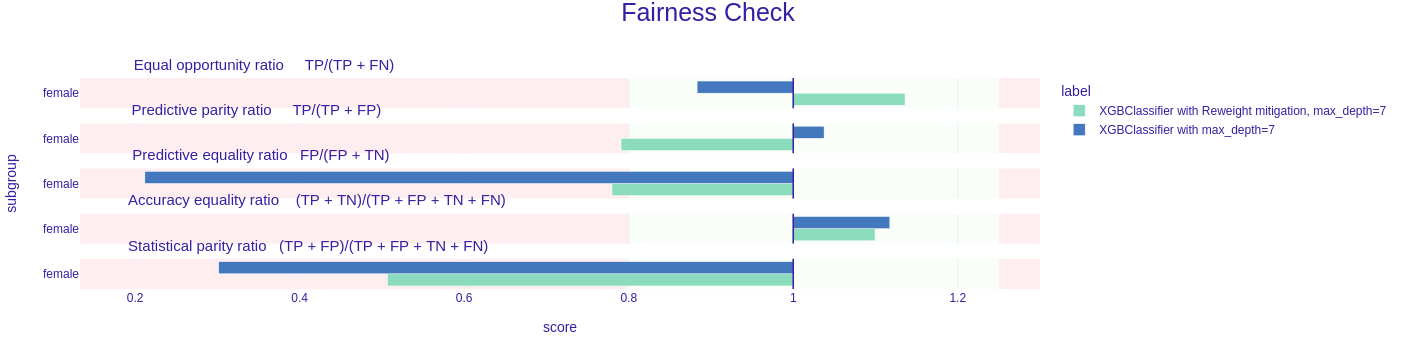

In [76]:
fobject_reweight.plot(fobject)

### 5. Compare the quality (performance) of the three models with their fairness coefficients. Is there any correlation?

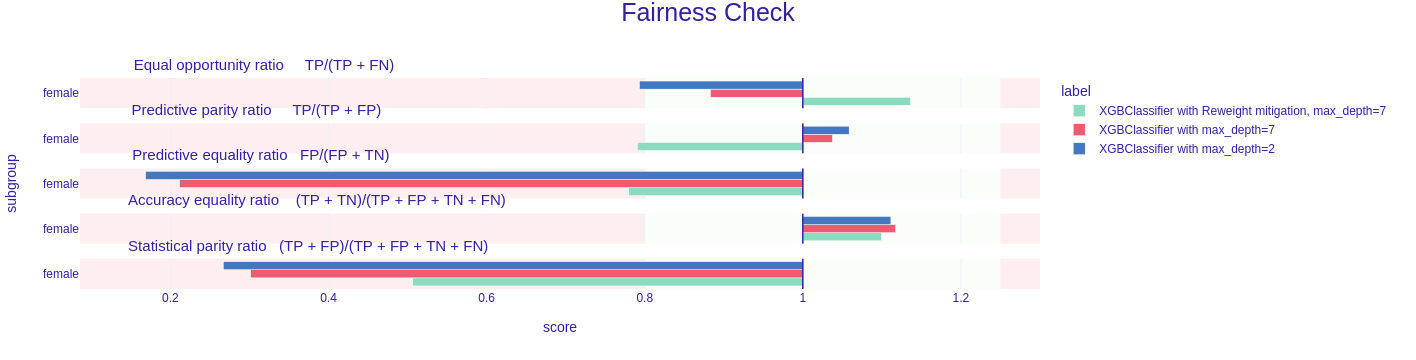

In [78]:
fobject_reweight.plot([fobject, fobject_2])

In [79]:
explainer.model_performance()

,recall,precision,f1,accuracy,auc
XGBClassifier with max_depth=7,0.66465,0.776344,0.716168,0.875729,0.928917


In [80]:
explainer_2.model_performance()

,recall,precision,f1,accuracy,auc
XGBClassifier with max_depth=2,0.638085,0.790486,0.706156,0.874736,0.928471


In [81]:
explainer_reweight.model_performance()

,recall,precision,f1,accuracy,auc
"XGBClassifier with Reweight mitigation, max_depth=7",0.630195,0.782751,0.698237,0.87151,0.926027
